### Данные

Захотелось сделать что-то хоть сколько-нибудь интересное. Поэтому решил поучить UNET. Нашел датасет от майкрософта на примерно 23k файлов с записями и около сотни файлов с шумами. Там же у них в репозитории файл `audiolib.py` для наложения шума. https://github.com/microsoft/MS-SNSD

In [1]:
import os
import glob
import random
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from torch.utils.data import Dataset, DataLoader
import audiolib

%matplotlib inline

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
CLEAN_DIR_TRAIN = 'MS-SNSD-master/clean_train'
NOISE_DIR_TRAIN = 'MS-SNSD-master/noise_train'
CLEAN_DIR_TEST = 'MS-SNSD-master/clean_test'
NOISE_DIR_TEST = 'MS-SNSD-master/noise_test'


SAMPLE_RATE = 16000
DURATION = 3.0
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

In [4]:
def get_file_paths(directory, extension='.wav'):
    return glob.glob(os.path.join(directory, f'*{extension}'))

train_clean_files = get_file_paths(CLEAN_DIR_TRAIN)
train_noise_files = get_file_paths(NOISE_DIR_TRAIN)
test_clean_files = get_file_paths(CLEAN_DIR_TEST)
test_noise_files = get_file_paths(NOISE_DIR_TEST)


print(f"Found {len(train_clean_files)} train clean files.")
print(f"Found {len(train_noise_files)} train noise files.")
print(f"Found {len(test_clean_files)} test clean files.")
print(f"Found {len(test_noise_files)} test noise files.")

Found 23075 train clean files.
Found 128 train noise files.
Found 1100 test clean files.
Found 51 test noise files.


Тут я очень извиняюсь, но моя реализация mel крайне медленная. Если в даталоадере делать ее при инициализации, то предпосчет занимает 45+ минут по tqdm. А при On the fly предсказание на одну эпоху > 1.5 часов. Не очень хочется столько ждать + предпосчет вынуждает фиксировать параметры спектрограммы. Пришлось пользоваться торчовыми реализациями. 

In [5]:
from functools import partial
from tqdm import tqdm

def mel(signal: np.ndarray, sample_rate: int, window_len, step_len, n_fft, mels, fmin, fmax, alpha=0.97, window='hann'):
    if window == 'hann':
        window_func = np.hanning
    elif window == 'hamming':
        window_func = np.hamming
    elif window == 'blackman':
        window_func = np.blackman
    else:
        raise NotImplemented("Window type not known")
    
    signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    
    frames_cnt = (len(signal) - window_len) // step_len + 1
    frames = np.zeros((frames_cnt, window_len))
    for i in range(frames_cnt):
        frames[i, :] = signal[i * step_len : i * step_len + window_len] * window_func(window_len)
    if window_len < n_fft:
        frames = np.hstack((frames, np.zeros((frames_cnt, n_fft - window_len))))
    
    stft = np.fft.rfft(frames, n=n_fft)
    stft_power = np.abs(stft) ** 2 / n_fft

    mel_to_hz = lambda mel: 700 * (10 ** (mel / 2595) - 1)
    hz_to_mel = lambda hz: 2595 * np.log10(1 + hz / 700)

    mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), mels + 2)
    hz_points = mel_to_hz(mel_points)
    bins = np.floor(n_fft * hz_points / sample_rate).astype(int)
    
    fbank = np.zeros((mels, n_fft // 2 + 1))
    for i in range(1, mels + 1):
        f_i0, f_i, f_i1 = bins[i - 1], bins[i], bins[i + 1]
        for f_k in range(f_i0, f_i):
            fbank[i - 1, f_k] = (f_k - f_i0) / (f_i - f_i0)
        for f_k in range(f_i, f_i1):
            fbank[i - 1, f_k] = (f_i1 - f_k) / (f_i1 - f_i)

    mel_spectrogram = np.dot(stft_power, fbank.T)
    mel_spectrogram = np.where(mel_spectrogram == 0, np.finfo(float).eps, mel_spectrogram)
    mel_spectrogram = 10 * np.log10(mel_spectrogram)
    return mel_spectrogram


class DenoisingDataset(Dataset):
    def __init__(self, clean_files, noise_files, audio_len=AUDIO_LEN, sample_rate=SAMPLE_RATE, n_mels=128):
        self.clean_files = clean_files
        self.noise_files = noise_files
        self.audio_len = audio_len
        self.sample_rate = sample_rate
        
        # self.mel_transform = partial(
        #     mel,
        #     sample_rate=sample_rate,
        #     window_len=1024,
        #     step_len=128,
        #     n_fft=1024,
        #     mels=n_mels,
        #     fmin=0,
        #     fmax=sample_rate / 2,
        #     alpha=0.97,
        #     window='hann'
        # )
        
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=128,
            n_mels=n_mels
        )
        
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
    
    
    def __len__(self):
        return len(self.clean_files)

    def _load_audio(self, path):
        audio, sr = audiolib.audioread(path)
        
        return audio

    def _adjust_length(self, audio):
        if len(audio) < self.audio_len:
            tile_count = (self.audio_len // len(audio)) + 1
            audio = np.tile(audio, tile_count)[:self.audio_len]
        elif len(audio) > self.audio_len:
            start = random.randint(0, len(audio) - self.audio_len)
            audio = audio[start : start + self.audio_len]
        return audio

    def __getitem__(self, idx):
        clean_path = self.clean_files[idx]
        noise_path = random.choice(self.noise_files)
        
        clean_audio = self._load_audio(clean_path)
        noise_audio = self._load_audio(noise_path)
        
        clean_audio = self._adjust_length(clean_audio)
        noise_audio = self._adjust_length(noise_audio)
        
        snr = random.uniform(0, 20)
        

        clean_norm, noise_norm, noisy_audio = audiolib.snr_mixer(clean_audio, noise_audio, snr)
        
        clean_tensor = torch.from_numpy(clean_norm).float()
        noisy_tensor = torch.from_numpy(noisy_audio).float()
        
        clean_mel = self.mel_transform(clean_tensor)
        clean_mel = self.amplitude_to_db(clean_mel)
        
        noisy_mel = self.mel_transform(noisy_tensor)
        noisy_mel = self.amplitude_to_db(noisy_mel)
        
        return {
            'noisy_mel': noisy_mel,
            'clean_mel': clean_mel,
            'noisy_audio': noisy_tensor,
            'clean_audio': clean_tensor,
            'snr': snr
        }



SNR: 4.90 dB
Mel shape: torch.Size([128, 376])


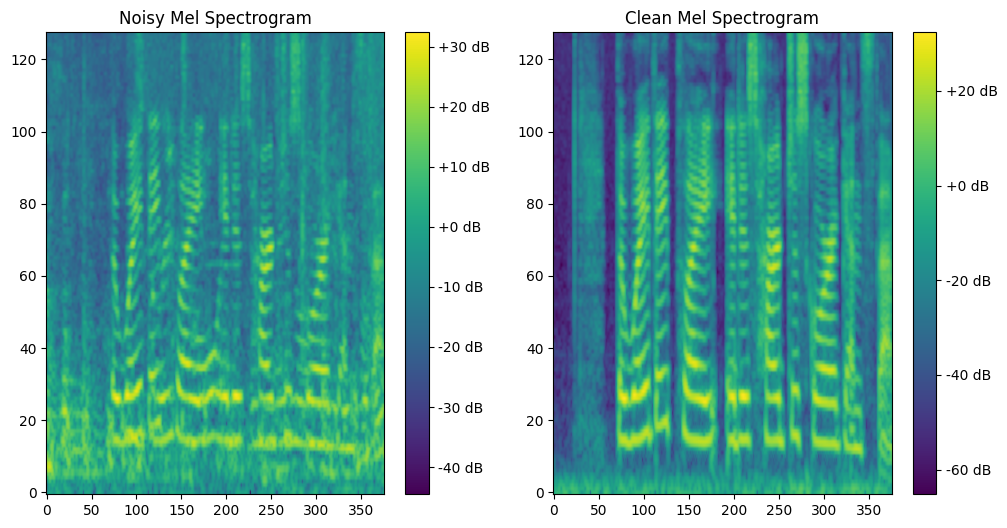

Clean Audio:


Noisy Audio:


In [6]:
train_dataset = DenoisingDataset(train_clean_files, train_noise_files)
test_dataset = DenoisingDataset(test_clean_files, test_noise_files)

sample = train_dataset[16]

noisy_mel = sample['noisy_mel']
clean_mel = sample['clean_mel']
noisy_audio = sample['noisy_audio']
clean_audio = sample['clean_audio']
snr = sample['snr']

print(f"SNR: {snr:.2f} dB")
print(f"Mel shape: {noisy_mel.shape}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Noisy Mel Spectrogram")
plt.imshow(noisy_mel.numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
plt.title("Clean Mel Spectrogram")
plt.imshow(clean_mel.numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.show()

print("Clean Audio:")
display(Audio(clean_audio.numpy(), rate=SAMPLE_RATE))

print("Noisy Audio:")
display(Audio(noisy_audio.numpy(), rate=SAMPLE_RATE))

## UNET

С радосью позаимствовал юнет с одной из старых домашек по CV)

In [7]:
import torch.nn as nn
import torchvision.transforms as transforms


class MiniBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.ln1 = nn.GroupNorm(1, out_channels)
        self.ln2 = nn.GroupNorm(1, out_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        return self.relu(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = MiniBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.block(x)
        skip_connection = x
        return self.maxpool(x), skip_connection
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upconv=True):
        super().__init__()
        self.block = MiniBlock(in_channels, out_channels)
        self.upconv = nn.ConvTranspose2d(out_channels, out_channels // 2, 2, stride=2) if upconv else nn.Identity()
        
    def forward(self, x, skip_connection):
        x = self._merge(x, skip_connection)
        x = self.block(x)
        return self.upconv(x)
        
    def _merge(self, x, skip_connection):
        _, _, h, w = x.shape
        cropped = transforms.CenterCrop((h, w))(skip_connection) 
        x = torch.cat([cropped, x], dim=1)
        return x
    
class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = MiniBlock(in_channels, out_channels)
        self.upconv = nn.ConvTranspose2d(out_channels, out_channels // 2, 2, stride=2)
        
    def forward(self, x):
        x = self.block(x)
        return self.upconv(x)

class UNET(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        self.encoder_blocks = nn.ModuleList([EncoderBlock(encoder_channels[i], encoder_channels[i+1]) for i in range(len(encoder_channels) - 1)])
        self.bottleneck = BottleNeck(encoder_channels[-1], decoder_channels[0])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(decoder_channels[i], decoder_channels[i+1]) for i in range(len(decoder_channels) - 2)])
        self.decoder_blocks.append(DecoderBlock(decoder_channels[-2], decoder_channels[-1], upconv=False))
        
        self.head = nn.Conv2d(decoder_channels[-1], 1, 1)
        
    def forward(self, x):
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x, skip_connection = encoder_block(x)
            skip_connections.append(skip_connection)
            
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        for decoder_block, skip_connection in zip(self.decoder_blocks, skip_connections):
            x = decoder_block(x, skip_connection)
        
        return self.head(x)

In [8]:
sample_input = torch.randn(2, 1, 80, 368)
model = UNET([1, 64, 128, 256], [512, 256, 128, 64])
model(sample_input).shape

torch.Size([2, 1, 80, 368])

### Train

In [9]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

@torch.no_grad()
def get_metrics(preds, targets):
    mse = nn.MSELoss()(preds, targets).item()
    mae = nn.L1Loss()(preds, targets).item()
    
    spectral_convergence = torch.norm(targets - preds, p='fro') / torch.norm(targets, p='fro')

    return {
        'MSE': mse,
        'MAE': mae,
        'Spectral_Convergence': spectral_convergence.item()
    }

def eval_step(model, test_dataloader, criterion, device='cuda'):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            noisy_mel = batch['noisy_mel'].unsqueeze(1).to(device)
            clean_mel = batch['clean_mel'].unsqueeze(1).to(device)
            
            outputs = model(noisy_mel)
            loss = criterion(outputs, clean_mel)
            
            valid_loss += loss.item()
    
    valid_loss /= len(test_dataloader)
    return valid_loss


def train_loop(model, train_dataloader, test_dataloader, epochs, optimizer, criterion, val_every=300, device='cuda', log_dir='./logs'):
    writer = SummaryWriter(log_dir)
    global_step = 0
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0.0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for i, batch in enumerate(pbar):
            model.train()
            noisy_mel = batch['noisy_mel'].unsqueeze(1).to(device)
            clean_mel = batch['clean_mel'].unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy_mel)
            loss = criterion(outputs, clean_mel)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            
            metrics = get_metrics(outputs, clean_mel)
            for key, value in metrics.items():
                writer.add_scalar(f'Train/{key}', value, global_step)
            
            writer.add_scalar('Train/Batch_Loss', loss.item(), global_step)
            global_step += 1
            
            pbar.set_postfix({'loss': loss.item()})
            
            if i % val_every == 0:
                valid_loss = eval_step(model, test_dataloader, criterion, device=device)
                writer.add_scalar('Valid/Loss', valid_loss, global_step)
                
                
            
        train_loss /= len(train_dataloader)
        
        valid_loss = eval_step(model, test_dataloader, criterion, device=device)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        writer.add_scalar('Train/Epoch_Loss', train_loss, epoch)
        writer.add_scalar('Valid/Epoch_Loss', valid_loss, epoch)
    
    writer.close()

In [46]:
train_dataloder = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = UNET([1, 64, 128, 256], [512, 256, 128, 64])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [47]:
train_loop(model, train_dataloder, test_dataloader, epochs=1, optimizer=optimizer, criterion=criterion, device='cuda')

100%|██████████| 69/69 [00:13<00:00,  5.18it/s]

Epoch [1/1], Train Loss: 187.3540, Valid Loss: 283.3965


In [56]:
def visualize_inference(model, dataset, idx, device='cuda'):
    model.eval()
    sample = dataset[idx]
    
    noisy_mel_input = sample['noisy_mel'].unsqueeze(0).unsqueeze(0).to(device)
    clean_mel = sample['clean_mel']
    noisy_mel = sample['noisy_mel']
    
    with torch.no_grad():
        denoised_mel = model(noisy_mel_input).squeeze(0).squeeze(0).cpu()
        
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Noisy Mel")
    plt.imshow(noisy_mel.numpy(), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(1, 3, 2)
    plt.title("Denoised Mel")
    plt.imshow(denoised_mel.numpy(), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(1, 3, 3)
    plt.title("Clean Mel")
    plt.imshow(clean_mel.numpy(), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    
    plt.show()


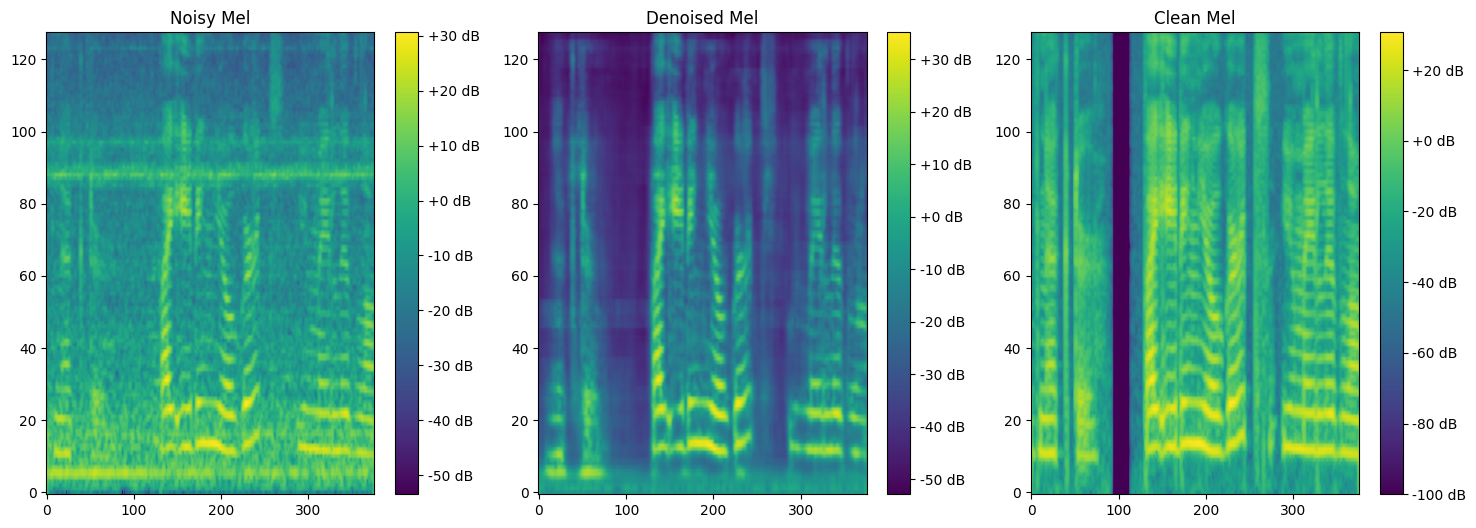

In [57]:
visualize_inference(model, test_dataset, 11)

In [58]:
device='cuda'

before_denoise_metrics = []
after_denoise_metrics = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        noisy_mel = batch['noisy_mel'].unsqueeze(1).to(device)
        clean_mel = batch['clean_mel'].unsqueeze(1).to(device)
        
        outputs = model(noisy_mel)
        before_denoise_metrics.append(get_metrics(noisy_mel, clean_mel))
        after_denoise_metrics.append(get_metrics(outputs, clean_mel))

100%|██████████| 69/69 [00:13<00:00,  5.24it/s]


In [60]:
before_denoise_average = {}
after_denoise_average = {}

for key in before_denoise_metrics[0].keys():
    before_denoise_average[key] = np.mean([m[key] for m in before_denoise_metrics])
    after_denoise_average[key] = np.mean([m[key] for m in after_denoise_metrics])
    print(f"{key}: Before Denoise = {before_denoise_average[key]:.4f}, After Denoise = {after_denoise_average[key]:.4f}")

MSE: Before Denoise = 534.3492, After Denoise = 279.4740
MAE: Before Denoise = 12.8546, After Denoise = 10.0573
Spectral_Convergence: Before Denoise = 0.7712, After Denoise = 0.5580


Также учил на L1, там метрики чуть лучше.

Там метрики такие: 
```
MSE: Before Denoise = 524.9857, After Denoise = 266.7525

MAE: Before Denoise = 12.8000, After Denoise = 8.8808

Spectral_Convergence: Before Denoise = 0.7681, After Denoise = 0.5474
```
(Разница в исходных из-за рандома)

Еще есть ощущение, что модель немножко переобучилась на типы шумов, которые есть в трейне (а их всего 128). MEL-спектрограммы из трейна выглядят намного чище. 